In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from os import path
import seaborn as sns
from operator import add
from scipy import sparse, io
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from dotenv import load_dotenv, find_dotenv
from sklearn.preprocessing import LabelEncoder
%matplotlib notebook

dotenv_path = find_dotenv()
load_dotenv(dotenv_path)

RAW_DATA_DIR = os.environ.get("RAW_DATA_DIR")
FEATURES_DATA_DIR = os.environ.get("FEATURES_DIR")

In [3]:
train = pd.read_csv(path.join(RAW_DATA_DIR, 'gender_age_train.csv'))
phone = pd.read_csv(path.join(RAW_DATA_DIR, 'phone_brand_device_model.csv'))
brand_map = pd.read_csv(path.join(FEATURES_DATA_DIR, 'brand_mapping.csv'))
model_map = pd.read_csv(path.join(FEATURES_DATA_DIR, 'model_mapping.csv'))

In [4]:
phone_t = train.merge(phone, how='left', on='device_id')
phone_t = phone_t.merge(brand_map, left_on='phone_brand', 
                        right_on='phone_brand_chinese', how='left')
phone_t = phone_t.merge(model_map, left_on='device_model', 
                        right_on='device_model_chinese', how='left')

In [5]:
phone_t = phone_t.drop(['phone_brand_chinese', 'device_model_chinese'], 1)
phone_t

,device_id,gender,age,group,phone_brand,device_model,phone_brand_latin,device_model_latin
0,-8076087639492063270,M,35,M32-38,小米,MI 2,xiaomi,redmi 2
1,-2897161552818060146,M,35,M32-38,小米,MI 2,xiaomi,redmi 2
2,-8260683887967679142,M,35,M32-38,小米,MI 2,xiaomi,redmi 2
3,-4938849341048082022,M,30,M29-31,小米,红米note,xiaomi,redmi note
4,245133531816851882,M,30,M29-31,小米,MI 3,xiaomi,MI 3h
5,245133531816851882,M,30,M29-31,小米,MI 3,xiaomi,MI 3
6,-1297074871525174196,F,24,F24-26,OPPO,R1C,OPPO,R1C
7,236877999787307864,M,36,M32-38,酷派,F2,coolpad,F2
8,-8098239495777311881,M,38,M32-38,小米,红米note,xiaomi,redmi note
9,176515041953473526,M,33,M32-38,vivo,X3T,vivo,X3T


In [6]:
most_pop_brand = phone_t['phone_brand_latin'].value_counts().head(10)
print most_pop_brand


xiaomi     19640
samsung    13706
huawei     13001
OPPO        5802
vivo        5658
meizu       4710
coolpad     3349
lenovo      2695
gionee      1124
HTC         1015
Name: phone_brand_latin, dtype: int64


In [7]:
female_brands = []
male_brands = []
for brand in most_pop_brand.index:
    app_rows = phone_t[ phone_t['phone_brand_latin'] == brand]
    female_brands.append(len(app_rows.query('gender == "F"')))
    male_brands.append(len(app_rows.query('gender == "M"')))

f_users = list(female_brands/most_pop_brand)
m_users = list(male_brands/most_pop_brand)

f_users = [ '%.3f' % elem for elem in f_users]
m_users = [ '%.3f' % elem for elem in m_users]

print "For the first 5 most installed phones the percentage of users are: "
print "- females: {}\n- males: {}".format(f_users[:], m_users[:])

For the first 5 most installed phones the percentage of users are: 
- females: ['0.346', '0.397', '0.327', '0.445', '0.470', '0.277', '0.322', '0.332', '0.359', '0.316']
- males: ['0.654', '0.603', '0.673', '0.555', '0.530', '0.723', '0.678', '0.668', '0.641', '0.684']


<IPython.core.display.Javascript object>


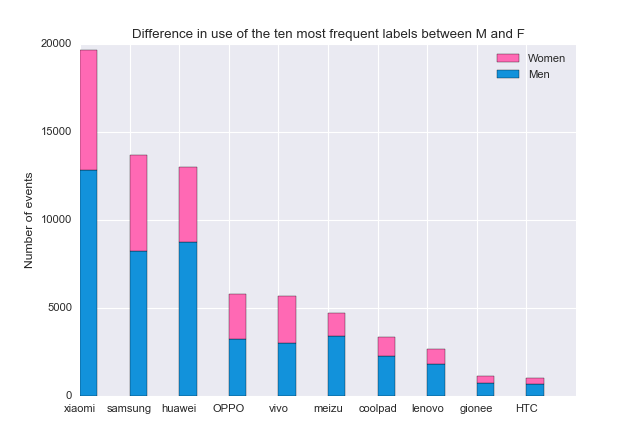

In [8]:

ind = np.arange(len(most_pop_brand))  # the x locations for the groups
width = 0.35

p1 = plt.bar(ind, male_brands, width, color="#1292db")
p2 = plt.bar(ind, female_brands, width, color="#ff69b4", bottom=male_brands)

my_xticks = most_pop_brand.index.values
plt.xticks(ind, my_xticks)
plt.ylabel('Number of events')
plt.title('Difference in use of the ten most frequent labels between M and F')
plt.legend((p2[0], p1[0]), ('Women', 'Men'))
plt.show()

### Most popular phones for female users

In [9]:
brand_fem = phone_t.query("gender == 'F'")
most_pop_brand = brand_fem['phone_brand_latin'].value_counts().head(10)
print most_pop_brand

xiaomi     6798
samsung    5443
huawei     4257
vivo       2660
OPPO       2581
meizu      1306
coolpad    1079
lenovo      894
gionee      403
HTC         321
Name: phone_brand_latin, dtype: int64


In [10]:
female_brands = []
male_brands = []
for brand in most_pop_brand.index:
    app_rows = phone_t[ phone_t['phone_brand_latin'] == brand]
    female_brands.append(len(app_rows.query('gender == "F"')))
    male_brands.append(len(app_rows.query('gender == "M"')))

tot = map(add, female_brands, male_brands)
total = pd.Series(tot, index=most_pop_brand.index)
f_users = list(female_brands/total)
m_users = list(male_brands/total)

f_users = [ '%.3f' % elem for elem in f_users]
m_users = [ '%.3f' % elem for elem in m_users]

print "For the most installed categories the percentage of users are: "
print "- females: {}\n- males: {}".format(f_users[:], m_users[:])


For the most installed categories the percentage of users are: 
- females: ['0.346', '0.397', '0.327', '0.470', '0.445', '0.277', '0.322', '0.332', '0.359', '0.316']
- males: ['0.654', '0.603', '0.673', '0.530', '0.555', '0.723', '0.678', '0.668', '0.641', '0.684']


<IPython.core.display.Javascript object>


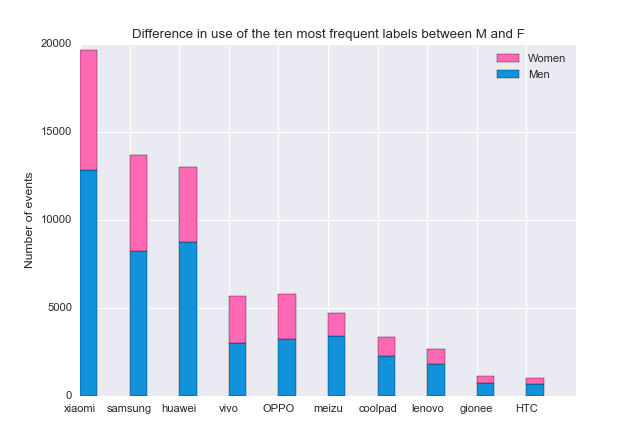

In [11]:

ind = np.arange(len(most_pop_brand))  # the x locations for the groups
width = 0.35

plt.figure()
p1 = plt.bar(ind, male_brands, width, color="#1292db")
p2 = plt.bar(ind, female_brands, width, color="#ff69b4", bottom=male_brands)

my_xticks = most_pop_brand.index.values
plt.xticks(ind, my_xticks)
plt.ylabel('Number of events')
plt.title('Difference in use of the ten most frequent labels between M and F')
plt.legend((p2[0], p1[0]), ('Women', 'Men'))
plt.show()

### Most popular phones for male users

In [12]:
brand_male = phone_t.query("gender == 'M'")
most_pop_brand = brand_male['phone_brand_latin'].value_counts().head(10)
print most_pop_brand

xiaomi     12842
huawei      8744
samsung     8263
meizu       3404
OPPO        3221
vivo        2998
coolpad     2270
lenovo      1801
gionee       721
HTC          694
Name: phone_brand_latin, dtype: int64


In [13]:
female_brands = []
male_brands = []
for brand in most_pop_brand.index:
    app_rows = phone_t[ phone_t['phone_brand_latin'] == brand]
    female_brands.append(len(app_rows.query('gender == "F"')))
    male_brands.append(len(app_rows.query('gender == "M"')))

tot = map(add, female_brands, male_brands)
total = pd.Series(tot, index=most_pop_brand.index)
f_users = list(female_brands/total)
m_users = list(male_brands/total)

f_users = [ '%.3f' % elem for elem in f_users]
m_users = [ '%.3f' % elem for elem in m_users]

print "For the first 5 most installed categories the percentage of users are: "
print "- females: {}\n- males: {}".format(f_users[:], m_users[:])

For the first 5 most installed categories the percentage of users are: 
- females: ['0.346', '0.327', '0.397', '0.277', '0.445', '0.470', '0.322', '0.332', '0.359', '0.316']
- males: ['0.654', '0.673', '0.603', '0.723', '0.555', '0.530', '0.678', '0.668', '0.641', '0.684']


<IPython.core.display.Javascript object>


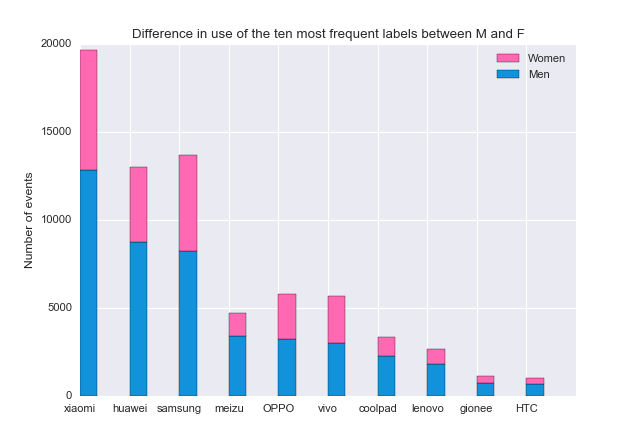

In [14]:
ind = np.arange(len(most_pop_brand))  # the x locations for the groups
width = 0.35

plt.figure()
p1 = plt.bar(ind, male_brands, width, color="#1292db")
p2 = plt.bar(ind, female_brands, width, color="#ff69b4", bottom=male_brands)

my_xticks = most_pop_brand.index.values
plt.xticks(ind, my_xticks)
plt.ylabel('Number of events')
plt.title('Difference in use of the ten most frequent labels between M and F')
plt.legend((p2[0], p1[0]), ('Women', 'Men'))
plt.show()

## MODELS

In [15]:
phone_t['brand_model'] = phone_t['phone_brand'].str.cat(phone_t['device_model'])

most_pop_brand = phone_t['brand_model'].value_counts().head(10)
print most_pop_brand

小米MI 3             4608
小米红米note           3016
小米MI 2S            2137
三星Galaxy Note 3    2070
小米MI 4             1914
三星Galaxy Note 2    1611
三星Galaxy S4        1574
华为荣耀6              1242
华为荣耀畅玩4X           1104
华为荣耀3C             1068
Name: brand_model, dtype: int64


In [16]:
latin_xticks = ['MI 3h', 'redmi note', 'MI 2S', 'Galaxy Note 3', 'MI 4', 'Galaxy Note 2', 'Galaxy S4',
                'honor 6', 'honor 4X', 'honor 3C']

In [17]:
female_brands = []
male_brands = []
for brand in most_pop_brand.index:
    app_rows = phone_t[ phone_t['brand_model'] == brand]
    female_brands.append(len(app_rows.query('gender == "F"')))
    male_brands.append(len(app_rows.query('gender == "M"')))

f_users = list(female_brands/most_pop_brand)
m_users = list(male_brands/most_pop_brand)

f_users = [ '%.3f' % elem for elem in f_users]
m_users = [ '%.3f' % elem for elem in m_users]

print "For the most installed categories the percentage of users are: "
print "- females: {}\n- males: {}".format(f_users[:], m_users[:])

For the most installed categories the percentage of users are: 
- females: ['0.377', '0.378', '0.359', '0.413', '0.313', '0.487', '0.379', '0.301', '0.319', '0.326']
- males: ['0.623', '0.622', '0.641', '0.587', '0.687', '0.513', '0.621', '0.699', '0.681', '0.674']


<IPython.core.display.Javascript object>


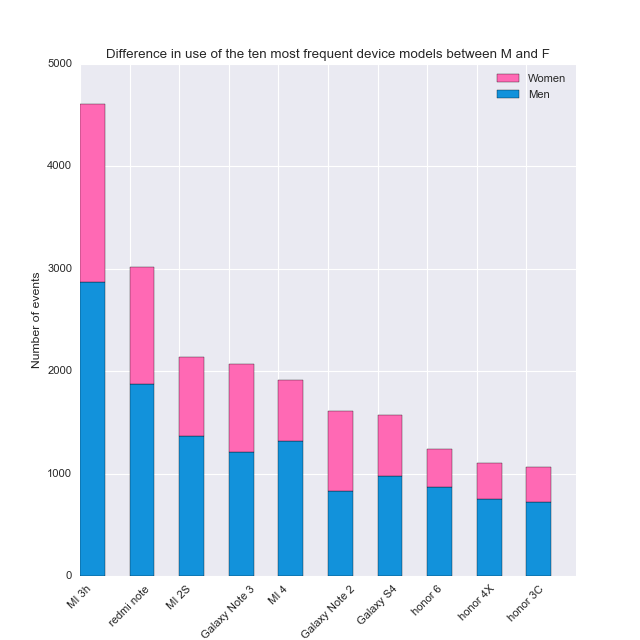

In [18]:
ind = np.arange(len(most_pop_brand))  # the x locations for the groups
width = 0.5
plt.figure(figsize=(8,8))
p1 = plt.bar(ind, male_brands, width, color="#1292db")
p2 = plt.bar(ind, female_brands, width, color="#ff69b4", bottom=male_brands)

plt.xticks(ind, latin_xticks, rotation=45)
plt.ylabel('Number of events')
plt.title('Difference in use of the ten most frequent device models between M and F')
plt.legend((p2[0], p1[0]), ('Women', 'Men'))
plt.show()


### Females devices

In [19]:
brand_fem = phone_t.query("gender == 'F'")
most_pop_brand = brand_fem['brand_model'].value_counts().head(10)
print most_pop_brand

小米MI 3             1736
小米红米note           1139
三星Galaxy Note 3     855
三星Galaxy Note 2     785
小米MI 2S             768
小米MI 4              599
三星Galaxy S4         597
三星Galaxy S3         390
华为荣耀6               374
小米红米                356
Name: brand_model, dtype: int64


In [20]:
latin_xticks = ['MI 3h', 'redmi note', 'Galaxy Note 3', 'Galaxy Note 2', 'MI 2S', 'MI 4', 'Galaxy S4',
                'Galaxy S3', 'honor 6', 'redmi']

In [21]:
female_brands = []
male_brands = []
for brand in most_pop_brand.index:
    app_rows = phone_t[ phone_t['brand_model'] == brand]
    female_brands.append(len(app_rows.query('gender == "F"')))
    male_brands.append(len(app_rows.query('gender == "M"')))

tot = map(add, female_brands, male_brands)
total = pd.Series(tot, index=most_pop_brand.index)
f_users = list(female_brands/total)
m_users = list(male_brands/total)

f_users = [ '%.3f' % elem for elem in f_users]
m_users = [ '%.3f' % elem for elem in m_users]

print "For the most installed categories the percentage of users are: "
print "- females: {}\n- males: {}".format(f_users[:], m_users[:])

For the most installed categories the percentage of users are: 
- females: ['0.377', '0.378', '0.413', '0.487', '0.359', '0.313', '0.379', '0.403', '0.301', '0.367']
- males: ['0.623', '0.622', '0.587', '0.513', '0.641', '0.687', '0.621', '0.597', '0.699', '0.633']


<IPython.core.display.Javascript object>


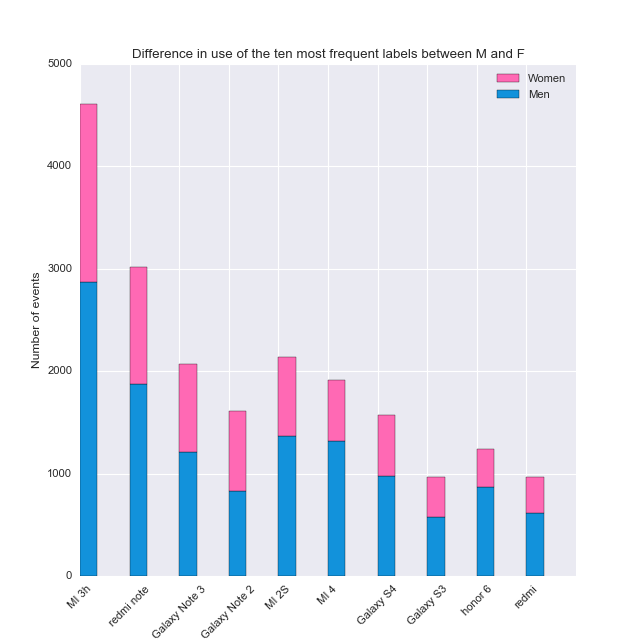

In [22]:
ind = np.arange(len(most_pop_brand))  # the x locations for the groups
width = 0.35
plt.figure(figsize=(8,8))
p1 = plt.bar(ind, male_brands, width, color="#1292db")
p2 = plt.bar(ind, female_brands, width, color="#ff69b4", bottom=male_brands)

plt.ylabel('Number of events')
plt.xticks(ind, latin_xticks, rotation=45)
plt.title('Difference in use of the ten most frequent labels between M and F')
plt.legend((p2[0], p1[0]), ('Women', 'Men'))
plt.show()

### Male models

In [23]:
brand_male = phone_t.query("gender == 'M'")
most_pop_brand = brand_male['brand_model'].value_counts().head(10)
print most_pop_brand

小米MI 3             2872
小米红米note           1877
小米MI 2S            1369
小米MI 4             1315
三星Galaxy Note 3    1215
三星Galaxy S4         977
华为荣耀6               868
三星Galaxy Note 2     826
华为荣耀畅玩4X            752
华为荣耀3C              720
Name: brand_model, dtype: int64


In [24]:
latin_xticks = ['MI 3h', 'redmi note', 'MI 2S', 'MI 4', 'Galaxy Note 3', 'Galaxy S4', 'honor 6',
                'Galaxy Note 2', 'honor 4X', 'honor 3C']

In [25]:
#phone_t[phone_t['brand_model']==most_pop_brand.index.values[9]]

In [26]:
female_brands = []
male_brands = []
for brand in most_pop_brand.index:
    app_rows = phone_t[ phone_t['brand_model'] == brand]
    female_brands.append(len(app_rows.query('gender == "F"')))
    male_brands.append(len(app_rows.query('gender == "M"')))

f_users = list(female_brands/most_pop_brand)
m_users = list(male_brands/most_pop_brand)

f_users = [ '%.3f' % elem for elem in f_users]
m_users = [ '%.3f' % elem for elem in m_users]

print "For the most installed categories the percentage of users are: "
print "- females: {}\n- males: {}".format(f_users[:], m_users[:])

For the most installed categories the percentage of users are: 
- females: ['0.604', '0.607', '0.561', '0.456', '0.704', '0.611', '0.431', '0.950', '0.468', '0.483']
- males: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']


<IPython.core.display.Javascript object>


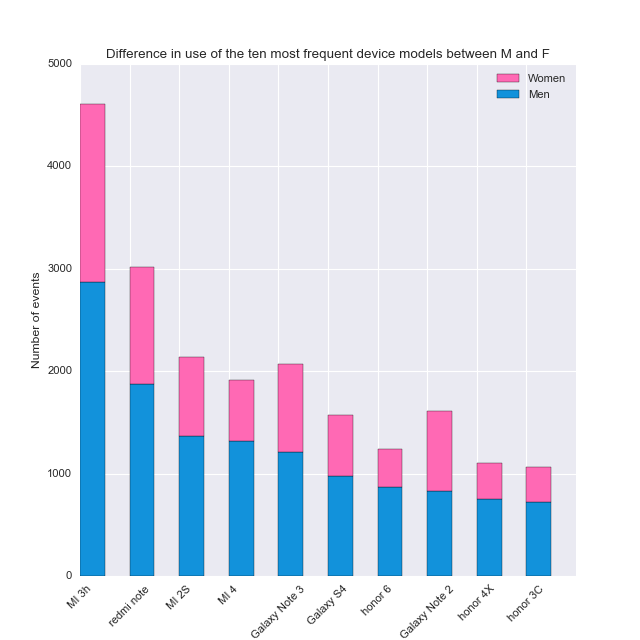

In [27]:
ind = np.arange(len(most_pop_brand))  # the x locations for the groups
width = 0.5
plt.figure(figsize=(8,8))
p1 = plt.bar(ind, male_brands, width, color="#1292db")
p2 = plt.bar(ind, female_brands, width, color="#ff69b4", bottom=male_brands)

plt.xticks(ind, latin_xticks, rotation=45)
plt.ylabel('Number of events')
plt.title('Difference in use of the ten most frequent device models between M and F')
plt.legend((p2[0], p1[0]), ('Women', 'Men'))
plt.show()


## Adding new features

In [28]:
specs_table = pd.read_csv(path.join(FEATURES_DATA_DIR, 'specs_table.csv'))
model_mapping = pd.read_csv(path.join(FEATURES_DATA_DIR, 'model_mapping.csv'))
brand_mapping = pd.read_csv(path.join(FEATURES_DATA_DIR, 'brand_mapping.csv'))

In [30]:
specs_table = pd.read_csv(path.join(FEATURES_DATA_DIR, 'specs_table.csv'))
model_mapping = pd.read_csv(path.join(FEATURES_DATA_DIR, 'model_mapping.csv'))
brand_mapping = pd.read_csv(path.join(FEATURES_DATA_DIR, 'brand_mapping.csv'))

phone_t = phone_t.drop_duplicates('device_id')

phone_t = phone_t.drop_duplicates('device_id')
phone_t = phone_t.rename( columns = {'phone_brand': 'phone_brand_chinese',
                                     'device_model': 'device_model_chinese',
                                     'phone_brand_latin': 'phone_brand',
                                     'device_model_latin': 'device_model'
                                     })

phone_specs = phone_t.merge(specs_table,
                 on=['phone_brand', 'device_model'],
                 how='left',
                 suffixes=['', '_R'])
phone_specs = phone_specs.fillna(-1)
phone_specs = phone_specs[phone_specs['price_eur'] != -1]


In [31]:
v = phone_specs['price_eur'].value_counts()
v.iloc[0] > sum(v.iloc[1:])/10

False

<IPython.core.display.Javascript object>


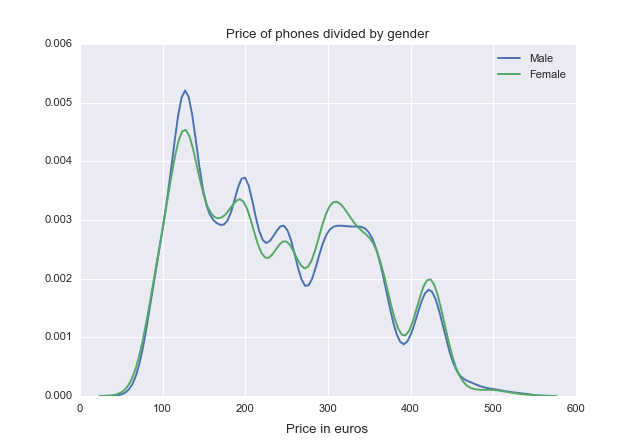

In [32]:
plt.figure()
sns.kdeplot(phone_specs.price_eur[phone_specs['gender'] == 'M'], label='Male')
sns.kdeplot(phone_specs.price_eur[phone_specs['gender'] == 'F'], label='Female')
plt.legend()
plt.title('Price of phones divided by gender')
plt.annotate('Price in euros', (0,0), (185, -25), xycoords='axes fraction', 
             textcoords='offset points', va='top')

<IPython.core.display.Javascript object>


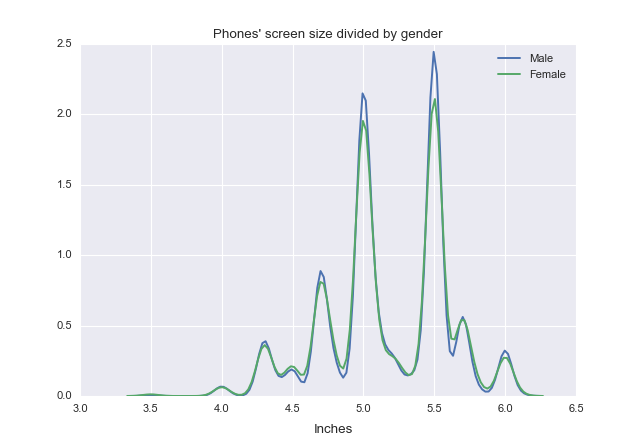

In [33]:
plt.figure()
sns.kdeplot(phone_specs.screen_size[phone_specs['gender'] == 'M'], label='Male')
sns.kdeplot(phone_specs.screen_size[phone_specs['gender'] == 'F'], label='Female')
plt.legend()
plt.title("Phones' screen size divided by gender")
plt.annotate('Inches', (0,0), (210, -25), xycoords='axes fraction', 
             textcoords='offset points', va='top')

<IPython.core.display.Javascript object>


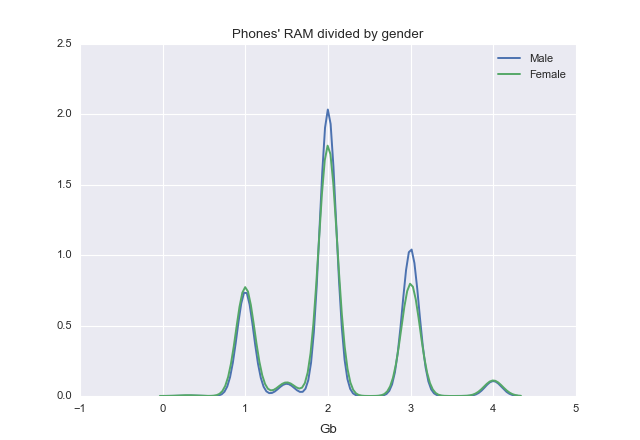

In [34]:
plt.figure()
sns.kdeplot(phone_specs.ram_gb[phone_specs['gender'] == 'M'], label='Male')
sns.kdeplot(phone_specs.ram_gb[phone_specs['gender'] == 'F'], label='Female')
plt.legend()
plt.title("Phones' RAM divided by gender")
plt.annotate('Gb', (0,0), (215, -25), xycoords='axes fraction', 
             textcoords='offset points', va='top')

<IPython.core.display.Javascript object>


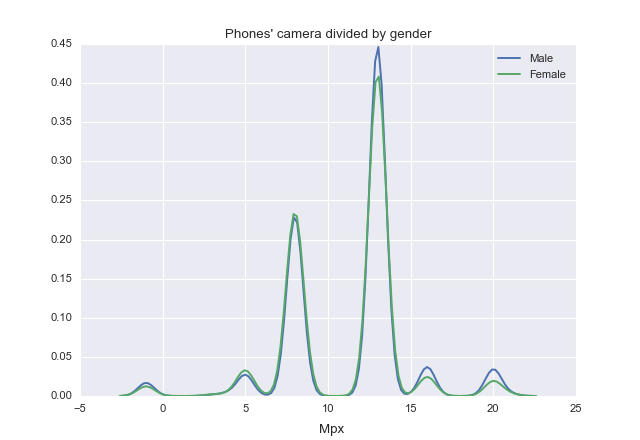

In [35]:
plt.figure()
sns.kdeplot(phone_specs.camera[phone_specs['gender'] == 'M'], label='Male')
sns.kdeplot(phone_specs.camera[phone_specs['gender'] == 'F'], label='Female')

plt.legend()
plt.title("Phones' camera divided by gender")
plt.annotate('Mpx', (0,0), (215, -25), xycoords='axes fraction', 
             textcoords='offset points', va='top')

<IPython.core.display.Javascript object>


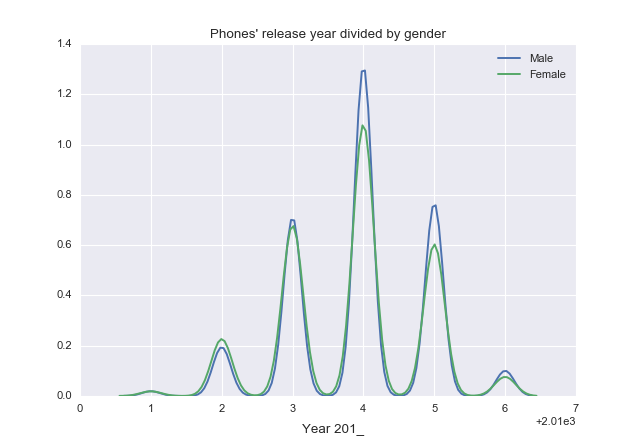

In [36]:
plt.figure()
sns.kdeplot(phone_specs.release_year[phone_specs['gender'] == 'M'], label='Male')
sns.kdeplot(phone_specs.release_year[phone_specs['gender'] == 'F'], label='Female')

plt.legend()
plt.title("Phones' release year divided by gender")
plt.annotate('Year 201_', (0,0), (200, -25), xycoords='axes fraction', 
             textcoords='offset points', va='top')